# Advances in Machine Learning with Big Data

### Jeremy Large
#### jeremy.large@economics.ox.ac.uk


&#169; Jeremy Large ; shared under [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/)

## 2. Being an econometrician *and* a data scientist

## Contents:

1. Introducing this course's dataset

1. **Being an econometrician _and_ a data scientist**

1. Overfit and regularization

1. Regularization through predictor/feature selection (Lasso etc.)

1. Resampling methods, and model selection

1. Classification

1. Decision trees, bagging, and random forests

1. Make a start on neural networks

1. Causal inference

1. Text classification (&#169; Tensorflow Authors)

1. Word2Vec (&#169; Tensorflow Authors)

1. Convolutional neural nets and image classification (Lucas Kruitwagen)

1. Transfer learning (Lucas Kruitwagen)

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
plt.rcParams['figure.figsize'] = [12, 4]

import sys, os
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO)

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())

UCI_LIB = os.path.join(REPO_DIR, 'lib')
UCI_DATA = os.path.join(REPO_DIR, 'data') 

sys.path.append(UCI_LIB)

UCI_DATA_FILE = os.path.join(UCI_DATA, 'raw.csv') 

from uci_retail_data import stock_codes, uci_files 

Populating the interactive namespace from numpy and matplotlib


### Pull in and prepare our data

In [2]:
if os.path.exists(UCI_DATA_FILE):
    df = uci_files.load_uci_file(UCI_DATA_FILE, uci_files.SHEET_NAME)
else:
    df = uci_files.load_uci_file(uci_files.REMOTE_FILE, uci_files.SHEET_NAME)
    df.to_csv(UCI_DATA_FILE)
    logging.info('Saving a copy to ' + UCI_DATA_FILE)

2022-04-25 14:15:19,692 INFO:Loading C:\Users\jerem\Documents\work\SBS\MFE\AMLBD\ox-sbs-ml-bd\data\raw.csv , sheet Year 2009-2010
2022-04-25 14:15:22,711 INFO:Loaded C:\Users\jerem\Documents\work\SBS\MFE\AMLBD\ox-sbs-ml-bd\data\raw.csv , sheet number one, obviously


Clean data:

In [3]:
# Here, I call the irrelevant lines 'invalids':
invalids = stock_codes.invalid_series(df)

Aggregate into invoices:

In [4]:
invoices = stock_codes.invoice_df(df, invalid_series=invalids)

In [5]:
invoices.head(2)

,customer,codes_in_invoice,items_in_invoice,invoice_spend,hour,month,words,country,words_per_item
Invoice,,,,,,,,,
489434,13085.0,8,166,505.3,7,200912,"{PINK, DOUGHNUT, TRINKET, SIZE, CHERRY, WHITE,...",United Kingdom,3.625
489435,13085.0,4,60,145.8,7,200912,"{BALL, ,, DOG, WITH, DESIGN, CAT, MEASURING, C...",United Kingdom,4.000


In [6]:
invoices.tail(2)

,customer,codes_in_invoice,items_in_invoice,invoice_spend,hour,month,words,country,words_per_item
Invoice,,,,,,,,,
538170,13969.0,25,133,317.59,19,201012,"{VINTAGE, BLACK, FLAG, GREEN, CARDS, METAL, PO...",United Kingdom,2.92
538171,17530.0,65,194,300.64,20,201012,"{VINTAGE, PINK, DOLLY, COSY, GREEN, DOLL, PLAC...",United Kingdom,2.20


In [7]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20577 entries, 489434 to 538171
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer          18969 non-null  float64
 1   codes_in_invoice  20577 non-null  int64  
 2   items_in_invoice  20577 non-null  int64  
 3   invoice_spend     20577 non-null  float64
 4   hour              20577 non-null  int64  
 5   month             20577 non-null  int64  
 6   words             20577 non-null  object 
 7   country           20577 non-null  object 
 8   words_per_item    20577 non-null  float64
dtypes: float64(3), int64(4), object(2)
memory usage: 1.6+ MB


### Set a prediction problem:

**Given the time, date, and complexity of an invoice, what's its expected spend per item shipped?**

> *helps us predict margins*

Note:

* This is a [supervised](https://en.wikipedia.org/wiki/Machine_learning#Supervised_learning) problem, rather than unsupervised

* It is also a regression problem, rather than [classification](https://en.wikipedia.org/wiki/Statistical_classification)

These will be boundaries in this course.

First, we'll attack this in a familiar way: using, as best we can, *linear regression*. 

*  However, we'll take time to compare two suitable `python` libraries for this.

### 1. [`statsmodels`](https://www.statsmodels.org/stable/index.html)

* package for established statistics; has [some of the feel](https://www.statsmodels.org/stable/example_formulas.html) of R

* *statsmodels: Econometric and statistical modeling with python* Seabold, Skipper, and Josef Perktold. Proceedings of the 9th Python in Science Conference, 2010.

* funded at [Google Summer of Code (GSOC) 2009-2017](https://summerofcode.withgoogle.com/) and by hedge fund [AQR](https://www.aqr.com)      

### 2. [`scikit-learn`](https://scikit-learn.org/stable/index.html)

* package for machine learning

* *Scikit-learn: Machine Learning in Python*, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

They both do linear regression.

#### Lets import statsmodels / scikit-learn and packages that they use:

In [8]:
import numpy as np    # fast handling of matrices of real numbers, and similar

import pandas as pd     # great tool for wielding and combining rectangular datasets with varied, named, columns



import sklearn

import statsmodels

In [9]:
# in both cases, we will have to import specifically the bits of the package that we need, for example:
import statsmodels.formula.api as smf

#### Reminder of linear regression:

We have an i.i.d. sequence of observations, $\{(y_i, x_i), i=0, 1, ...\}$ where we are interested in moments of the R.V. $y_i$, conditional on the multivariate R.V.  $x_i$ (of length, say, $p$). 

We *postulate* a linear relationship of the following form:

\begin{equation}
y_i = x_i ' \beta + \epsilon_i,
\end{equation}
where $\beta$ is a vector of parameters of length $p$, and the i.i.d. sequence of random variables $\{\epsilon_i\}$ is independent of the regressors $\{x_i\}$

#### A personal story:

Now, what do I mean here by the word: *'postulate'*? 

For the econometrician in me, it means I *sincerely assert*.

For the machine learner in me, I'm not sure that's quite it. It's more that - pragmatically - I entertain this model.

* an important part of this course will be to flesh-out this comparison

**Exercise/reading**: [Breiman](https://projecteuclid.org/euclid.ss/1009213726#ui-tabs-1) formulates something like this as *Data modelling* versus *Algorithmic modelling*. Take a look and prepare to discuss in class.

### 1. Fitting a linear regression with `statsmodels`

Describe the model in natural statistician's terms:

In [10]:
formula_string = 'np.log(invoice_spend/items_in_invoice) ~ np.log(codes_in_invoice) + hour + month + words_per_item'

Specify that the model is OLS:

In [11]:
lm1 = smf.ols(formula=formula_string, data=invoices)

Common, pythonic, step, next, namely to `fit()`:

In [12]:
fit = lm1.fit()

In [13]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     np.log(invoice_spend / items_in_invoice)   R-squared:                       0.021
Model:                                                  OLS   Adj. R-squared:                  0.021
Method:                                       Least Squares   F-statistic:                     109.0
Date:                                      Mon, 25 Apr 2022   Prob (F-statistic):           4.55e-92
Time:                                              14:15:32   Log-Likelihood:                -19801.
No. Observations:                                     20577   AIC:                         3.961e+04
Df Residuals:                                         20572   BIC:                         3.965e+04
Df Model:                                                 4                                         
Covariance Type:                                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   50.6791     34.101      1.486      0.137     -16.161     117.519
np.log(codes_in_invoice)    -0.0378      0.005     -7.717      0.000      -0.047      -0.028
hour                         0.0059      0.002      3.213      0.001       0.002       0.010
month                       -0.0002      0.000     -1.470      0.142      -0.001    8.32e-05
words_per_item               0.0633      0.007      8.681      0.000       0.049       0.078
==============================================================================
Omnibus:                     2976.262   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21367.662
Skew:                           0.495   Prob(JB):                         0.00
Kurtosis:                       7.893   Cond. No.                     1.55e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The 'condition number' refers to $X'X$ -- and indicates how stably we can expect to invert that matrix

#### Comments on linear regression with `statsmodels`

* Thorough implementation of linear regression, elegant presentation, including tests:
    * significance tests (t-stats, F-tests, p-values, ...)
    * specification tests

* Imagine these tests pass (though they don't here, see JB and Condition)
    * we may conclude that we now *know* the Data Generating Process
       * our parametric modelling has been successful
    * we understand statistical aspects of the mechanisms out there
    * -> we are in a position to offer *explanations* of past, present and future observation
    

* However, standard reporting from `statsmodels` is fairly negative for my specifiation of the linear regression model on this data
    * Message: this is not much use, come back with something that describes reality better

* All the data has been used in fitting the regression
    * like e.g. MLEs, resulting estimates are statistically *efficient*.
    * But, to use up all the data like that:
      * was that greedy?
      * was it prudent?

### 2. Fitting a linear regression with `scikit-learn`

In the case of `scikit-learn`, there are preliminaries to go over.

In [14]:
# Reminder of our formulation of this regression:
formula_string

'np.log(invoice_spend/items_in_invoice) ~ np.log(codes_in_invoice) + hour + month + words_per_item'

In [15]:
#  First, we'll have to build some additional columns in our dataframe to do logariths etc.:
invoices['log_item_spend'] = np.log(invoices.invoice_spend / invoices.items_in_invoice)
invoices['log_n_codes'] = np.log(invoices.codes_in_invoice)

In [16]:
# Regarding this, set out `y` and `X` variables:
y = pd.DataFrame(invoices['log_item_spend'])
X = invoices[['log_n_codes', 'hour', 'month', 'words_per_item']] 

In [17]:
#  pull in scikit-learn libraries:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [18]:
model = LinearRegression()

#### `.fit()` - first of two central functions/methods in `scikit-learn`

In [19]:
model.fit(X, y)

LinearRegression()

#### `.predict()` - the second of the two

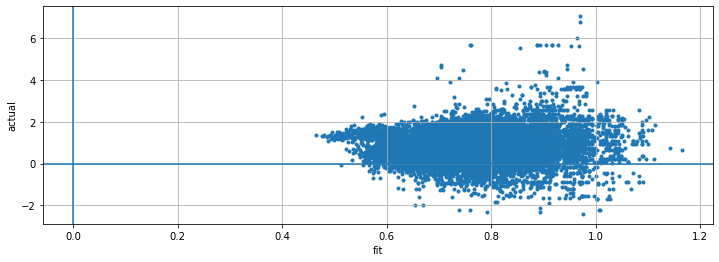

In [20]:
y_hat = model.predict(X)
plt.scatter(y_hat, y, marker='.')
plt.grid(); plt.xlabel('fit'); plt.ylabel('actual'); plt.axvline(); plt.axhline(); plt.show()

In [21]:
print('intercept is ', model.intercept_)
print('coefficients are ', model.coef_)
print('R2 is ', model.score(X, y))
print('MSE of prediction is', metrics.mean_squared_error(model.predict(X), y))

intercept is  [50.67914996]
coefficients are  [[-0.03775424  0.00592188 -0.0002493   0.06332345]]
R2 is  0.02075104873480338
MSE of prediction is 0.4012000071461238


We note that the Mean Square Error of the target, anyway, is:

In [22]:
np.round(invoices.log_item_spend.var(), 4)

0.4097

-> We can confirm by checking back that these are the same numbers as those obtained earlier with `statsmodels`

#### Observations so far about linear regression with `scikit-learn`

The linear regression feels much less slick than `statsmodels`

* we have to do more work to prepare it

* it only presents the details of its fit, if we interrogate oddly-named attributes like `.coef_`

* it doesn't seem to offer either specification, or significance, testing

In fact, it seems hard to extract from it anything much at all, relating to its *linear* structure



#### Lets push `scikit-learn` harder, to find out where it excels

#### Separate testing data from training data: the [KFold split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [23]:
from sklearn.model_selection import KFold

*Introduction to Statistical Learning* 5.1.3

#### We're going to loop through data, so we write a function to encapsulate that:

Take a look at [`train_n_test()`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L27)

In [24]:
from sbs_sklearn import train_n_test

#### ... and a helper function to plot diagrams:

Take a look at [`plot_kfold_scores()`](https://github.com/jeremy-large/ox-sbs-ml-bd/blob/master/lib/sbs_sklearn.py#L73)

In [25]:
from sbs_sklearn import plot_kfold_scores

#### Now lets deploy `scikit-learn` several times, distinguishing `train` from `test`:

In [26]:
scores = train_n_test(X, y, 6, update_frequency=1, concise=False)

2022-04-25 14:15:34,402 INFO:In study 1/6, train on 17147 randomly selected points; then test on the other 3430: first few test points = [12 13 15 21 25] 
2022-04-25 14:15:34,410 INFO:In study 2/6, train on 17147 randomly selected points; then test on the other 3430: first few test points = [ 6 11 19 31 38] 
2022-04-25 14:15:34,418 INFO:In study 3/6, train on 17147 randomly selected points; then test on the other 3430: first few test points = [ 8 14 18 27 28] 
2022-04-25 14:15:34,426 INFO:In study 4/6, train on 17148 randomly selected points; then test on the other 3429: first few test points = [ 3  5  7  9 16] 
2022-04-25 14:15:34,434 INFO:In study 5/6, train on 17148 randomly selected points; then test on the other 3429: first few test points = [ 1  2 10 17 23] 
2022-04-25 14:15:34,443 INFO:In study 6/6, train on 17148 randomly selected points; then test on the other 3429: first few test points = [ 0  4 20 26 29] 


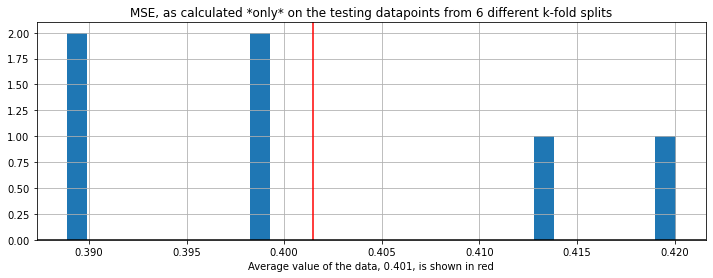

In [27]:
plot_kfold_scores(scores)

### Comments on linear regression with `scikit-learn`

* Correct implementation of linear regression

* Not focused on standard testing for linear regression
    * significance tests (t-stats, F-tests, p-values, ...)
    * specification tests
    

* Our model failed every specification test that `statsmodel` threw at it

* -> YET (per `scikit-learn`): it had a decent r2 on unseen data
    * Pragmatism: this model, for all its faults, can be used
    

* To embody more of a Machine Learning paradigm, we reprioritize:
    * prediction [`.predict() `] as compared to explanation
    * out-of-sample testing, as compared to specification testing
    * empirical distribution of our statistic, as compared to an asymptotic limit theory for it
    

To embody more of a Machine Learning paradigm, we reprioritize:
* prediction [`.predict() `] as compared to explanation
* out-of-sample testing, as compared to specification testing
* empirical distribution of our statistic, as compared to an asymptotic limit theory for it

### > In an abundance of data, and for some purposes, this reprioritization will make sense

* leaves us flexible in new dimensions

**Exercise**: apply the K-fold regression approach with number of folds equal to a tenth of the number of observations. Plot a histogram of the result, and discuss its meaning, as well as why it takes so long to compute.